In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import optimize
import regex as re


In [52]:
df = pd.read_csv('../other/frac_merge_peak.csv')


In [53]:
df['Field_Code'] = pd.Categorical(df['XEC_FIELD']).codes
df['Reservoir_Code'] = pd.Categorical(df['Reservoir']).codes


In [54]:
df.columns


Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak', u'Field_Code', u'Reservoir_Code'],
      dtype='object')

In [24]:
df.groupby(['XEC_FIELD', 'Field_Code'])['Field_Code'].count()


XEC_FIELD        Field_Code
COTTONWOOD DRAW  0             14
DIXIELAND        1             47
FORD, WEST       2             91
GRISHAM          3              9
PHANTOM          4              7
RED HILLS        5              1
STATELINE        6              3
TWO GEORGES      7              6
Name: Field_Code, dtype: int64

In [25]:
df.groupby(['Reservoir', 'Reservoir_Code'])['Reservoir'].count()


Reservoir         Reservoir_Code
Wolfcamp Shale A  0                 89
Wolfcamp Shale C  1                 14
Wolfcamp Shale D  2                 75
Name: Reservoir, dtype: int64

In [26]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster', u'Field_Code', u'Reservoir_Code']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape


(133, 21)

In [27]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))


In [28]:
X_lasso_train = X_train[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_train_std = standardize_2sd(X_lasso_train)
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_lasso_train_std, y_train)
print 'Train R2: {0}'.format(model.score(X_lasso_train_std, y_train))
X_lasso_test = X_test[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_test_std = standardize_2sd_test(X_lasso_test, X_lasso_train)
print 'Test R2: {0}'.format(model.score(X_lasso_test_std, y_test))


Train R2: 0.506618464039
Test R2: 0.188315827225


In [34]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='reservoir', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)
    

In [46]:
run_pooled = True

In [47]:
data = dict(x=X_lasso_train_std, y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    if run_pooled:
        trc_pooled = pm.backends.text.load('../other/traces_txt/trc_pooled')
    else:
        start = pm.find_MAP()
        trace = pm.backends.Text('../other/traces_txt/trc_pooled')
        trc_pooled = pm.sample(2000, njobs=1, step=step, start=start, trace=trace)     
    

Applied log-transform to sd and added transformed sd_log_ to model.


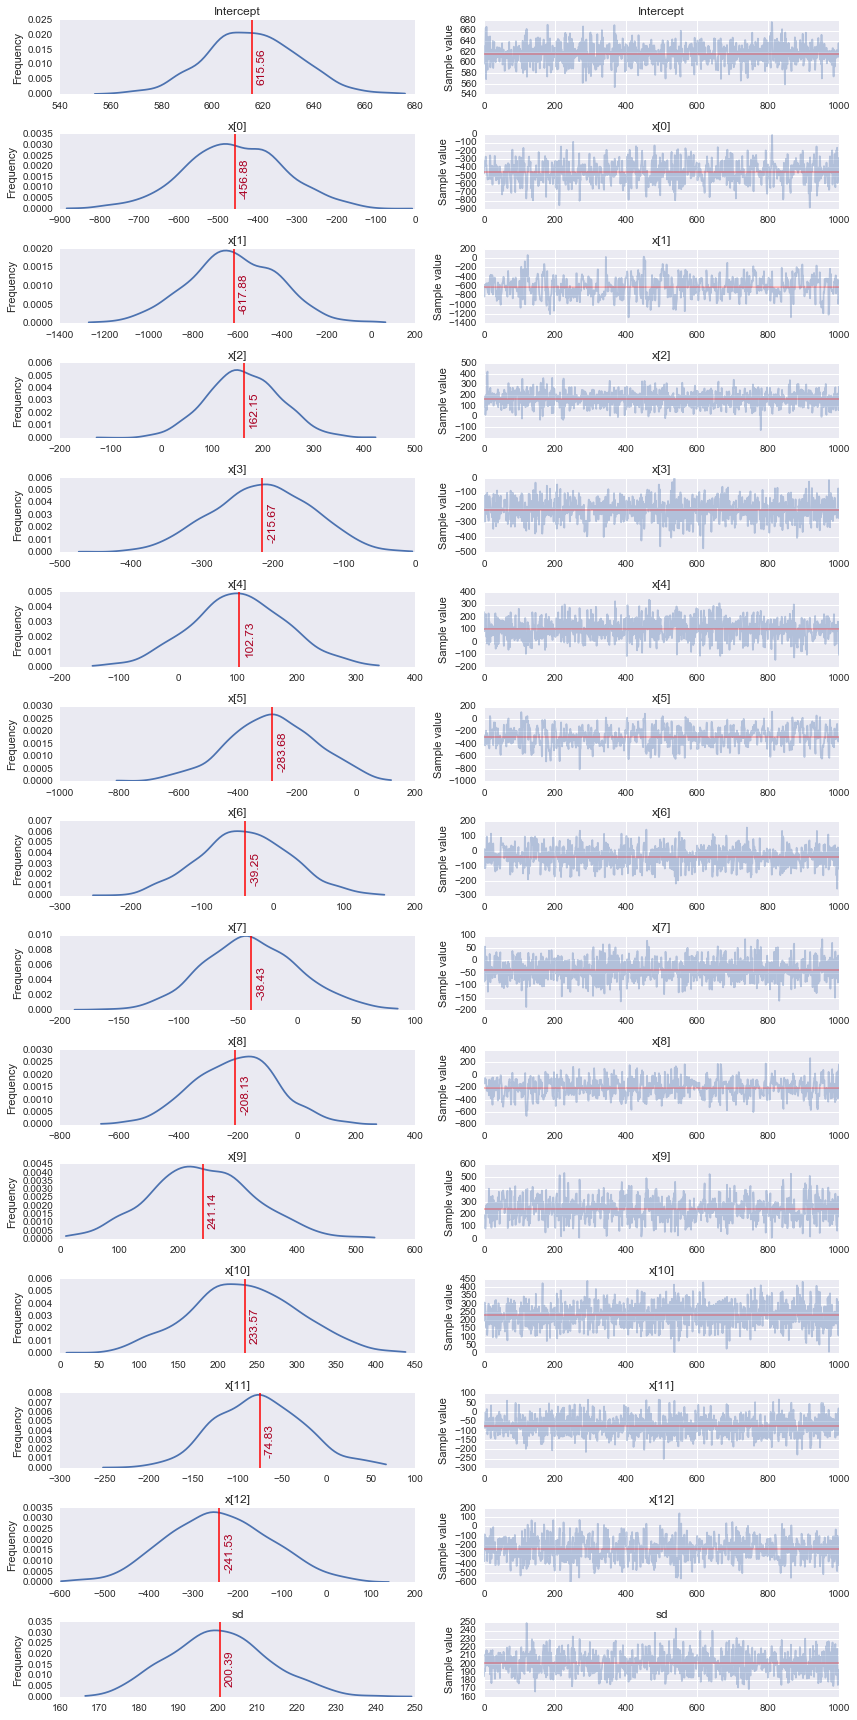

In [48]:
plot_traces(trc_pooled, retain=1000)


In [44]:
ppc_pooled = pm.sample_ppc(trc_pooled[-1000:], samples=500, model=mdl_pooled, size=50)
y_pred1 = ppc_pooled['y'].mean(0).mean(0).T
waic_pooled = pm.stats.waic(model=mdl_pooled, trace=trc_pooled[-1000:])
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred1)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred1))
print 'Train_WAIC: {0}'.format(waic_pooled)

Train_RMSE: 188.790015854
Train_R2: 0.505341979394
Train_WAIC: 1806.96252333


//anaconda/lib/python2.7/site-packages/pymc3/stats.py:138: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


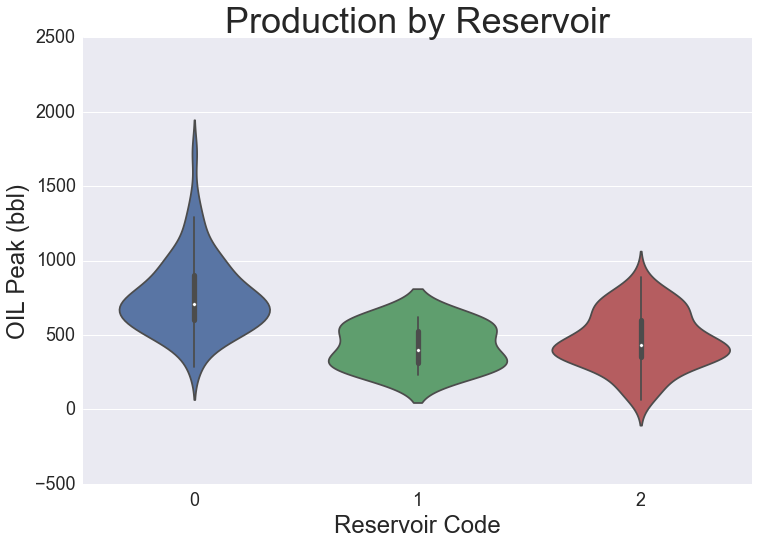

In [78]:
y_plot = pd.concat((y_train, X_train['Reservoir_Code']), axis=1)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.violinplot(y_plot['OIL_Peak'], groupby=y_plot['Reservoir_Code'])
ax.set_title('Production by Reservoir', fontsize=36)
ax.set_xlabel('Reservoir Code', fontsize=24)
ax.set_ylabel('OIL Peak (bbl)', fontsize=24)
font_size = 18
font_name = 'sans'
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
# plt.savefig('../other/figures/reservoir_violinplot', dpi=400)

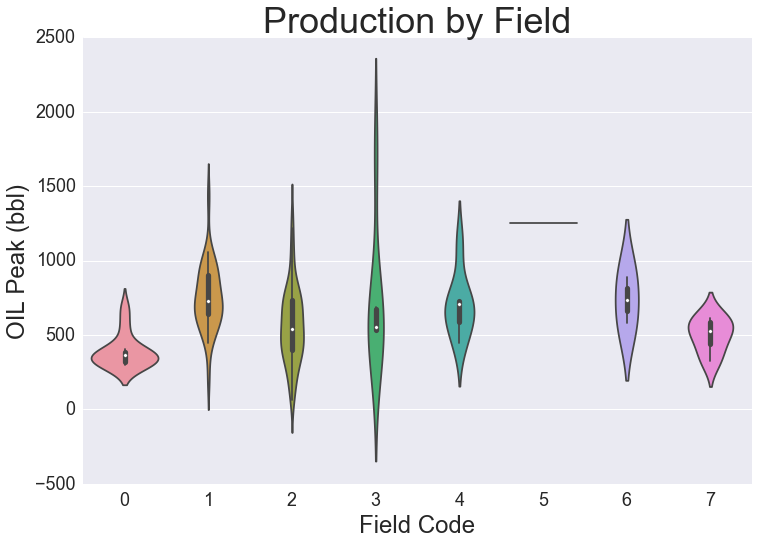

In [81]:
y_plot = pd.concat((y_train, X_train['Field_Code']), axis=1)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.violinplot(y_plot['OIL_Peak'], groupby=y_plot['Field_Code'])
ax.set_title('Production by Field', fontsize=36)
ax.set_xlabel('Field Code', fontsize=24)
ax.set_ylabel('OIL Peak (bbl)', fontsize=24)
font_size = 18
font_name = 'sans'
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
# plt.savefig('../other/figures/field_violinplot', dpi=400)

In [55]:
x = pd.concat((X_lasso_train_std, X_train['Reservoir_Code']), axis=1)
x.columns


Index([u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft',
       u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc',
       u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure',
       u'Fluid_Gal/Perf', u'Reservoir_Code'],
      dtype='object')

In [58]:
run_reservoir = True

In [59]:
with pm.Model() as mdl_reservoir:
    
    # define hyperpriors for group nodes
    mu_b0 = pm.Normal('mu_b0', mu=0., sd=100)
    sigma_b0 = pm.Uniform('sigma_b0', lower=0, upper=100)
    mu_b1 = pm.Normal('mu_b1', mu=0., sd=100)
    sigma_b1 = pm.Uniform('sigma_b1', lower=0, upper=100)
    mu_b2 = pm.Normal('mu_b2', mu=0., sd=100)
    sigma_b2 = pm.Uniform('sigma_b2', lower=0, upper=100)
    mu_b3 = pm.Normal('mu_b3', mu=0., sd=100)
    sigma_b3 = pm.Uniform('sigma_b3', lower=0, upper=100)
#     mu_b4 = pm.Normal('mu_b4', mu=0., sd=100)
#     sigma_b4 = pm.Uniform('sigma_b4', lower=0, upper=100)
#     mu_b5 = pm.Normal('mu_b5', mu=0., sd=100)
#     sigma_b5 = pm.Uniform('sigma_b5', lower=0, upper=100)
#     mu_b6 = pm.Normal('mu_b6', mu=0., sd=100)
#     sigma_b6 = pm.Uniform('sigma_b6', lower=0, upper=100)
#     mu_b7 = pm.Normal('mu_b7', mu=0., sd=100)
#     sigma_b7 = pm.Uniform('sigma_b7', lower=0, upper=100)
#     mu_b8 = pm.Normal('mu_b8', mu=0., sd=100)
#     sigma_b8 = pm.Uniform('sigma_b8', lower=0, upper=100)
#     mu_b9 = pm.Normal('mu_b9', mu=0., sd=100)
#     sigma_b9 = pm.Uniform('sigma_b9', lower=0, upper=100)
#     mu_b10 = pm.Normal('mu_b10', mu=0., sd=100)
#     sigma_b10 = pm.Uniform('sigma_b10', lower=0, upper=100)
#     mu_b11 = pm.Normal('mu_b11', mu=0., sd=100)
#     sigma_b11 = pm.Uniform('sigma_b11', lower=0, upper=100)
#     mu_b12 = pm.Normal('mu_b12', mu=0., sd=100)
#     sigma_b12 = pm.Uniform('sigma_b12', lower=0, upper=100)
#     mu_b13 = pm.Normal('mu_b13', mu=0., sd=100)
#     sigma_b13 = pm.Uniform('sigma_b13', lower=0, upper=100)

    # define priors, use Normal
    b0 = pm.Normal('b0_Reservoir_Code', mu=mu_b0, sd=sigma_b0, shape=x['Reservoir_Code'].nunique())
    b1 = pm.Normal('b1_Clusters/Stage', mu=mu_b1, sd=sigma_b1, shape=x['Reservoir_Code'].nunique())
    b2 = pm.Normal('b2_Perfs/Cluster', mu=mu_b2, sd=sigma_b2, shape=x['Reservoir_Code'].nunique())
    b3 = pm.Normal('b3_#_of_Stages', mu=mu_b3, sd=sigma_b3, shape=x['Reservoir_Code'].nunique())
    b4 = pm.Normal('b4_ISIP/Ft', mu=0, sd=100)
    b5 = pm.Normal('b5_Rate/Ft', mu=0, sd=100)
    b6 = pm.Normal('b6_Rate/Perf', mu=0, sd=100)
    b7 = pm.Normal('b7_Avg_Prop_Conc', mu=0, sd=100)
    b8 = pm.Normal('b8_Max_Prop_Conc', mu=0, sd=100)
    b9 = pm.Normal('b9_Rate/Cluster', mu=0, sd=100)
    b10 = pm.Normal('b10_Max_Rate', mu=0, sd=100)
    b11 = pm.Normal('b11_Avg_Pressure', mu=0, sd=100)
    b12 = pm.Normal('b12_Max_Pressure', mu=0, sd=100)    
    b13 = pm.Normal('b13_Fluid_Gal/Perf', mu=0, sd=100)    
    
    # define model error
    epsilon = pm.Uniform('eps', lower=0, upper=100)
    
    # define linear model
    y =    ( b0[x['Reservoir_Code']] +
             b1[x['Reservoir_Code']] * x['Clusters/Stage'] + 
             b2[x['Reservoir_Code']] * x['Perfs/Cluster'] +
             b3[x['Reservoir_Code']] * x['#_of_Stages'] +
             b4 * x['ISIP/Ft'] +
             b5 * x['Rate/Ft'] +
             b6 * x['Rate/Perf'] +
             b7 * x['Avg_Prop_Conc'] +
             b8 * x['Max_Prop_Conc'] +
             b9 * x['Rate/Cluster'] +
             b10 * x['Max_Rate'] +
             b11 * x['Avg_Pressure'] +
             b12 * x['Max_Pressure'] +
             b13 * x['Fluid_Gal/Perf'])

    ## Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('likelihood', mu=y, sd=epsilon, observed=y_train)
 
    # run model
    if run_reservoir:
        trc_reservoir = pm.backends.text.load('../other/traces_txt/trc_reservoir')
    else:
        step = pm.NUTS()
        start = pm.find_MAP()
        trace = pm.backends.Text('../other/traces_txt/trc_reservoir')
        trc_reservoir = pm.sample(2000, njobs=1, step=step, start=start, trace=trace)     


Applied interval-transform to sigma_b0 and added transformed sigma_b0_interval_ to model.
Applied interval-transform to sigma_b1 and added transformed sigma_b1_interval_ to model.
Applied interval-transform to sigma_b2 and added transformed sigma_b2_interval_ to model.
Applied interval-transform to sigma_b3 and added transformed sigma_b3_interval_ to model.
Applied interval-transform to eps and added transformed eps_interval_ to model.


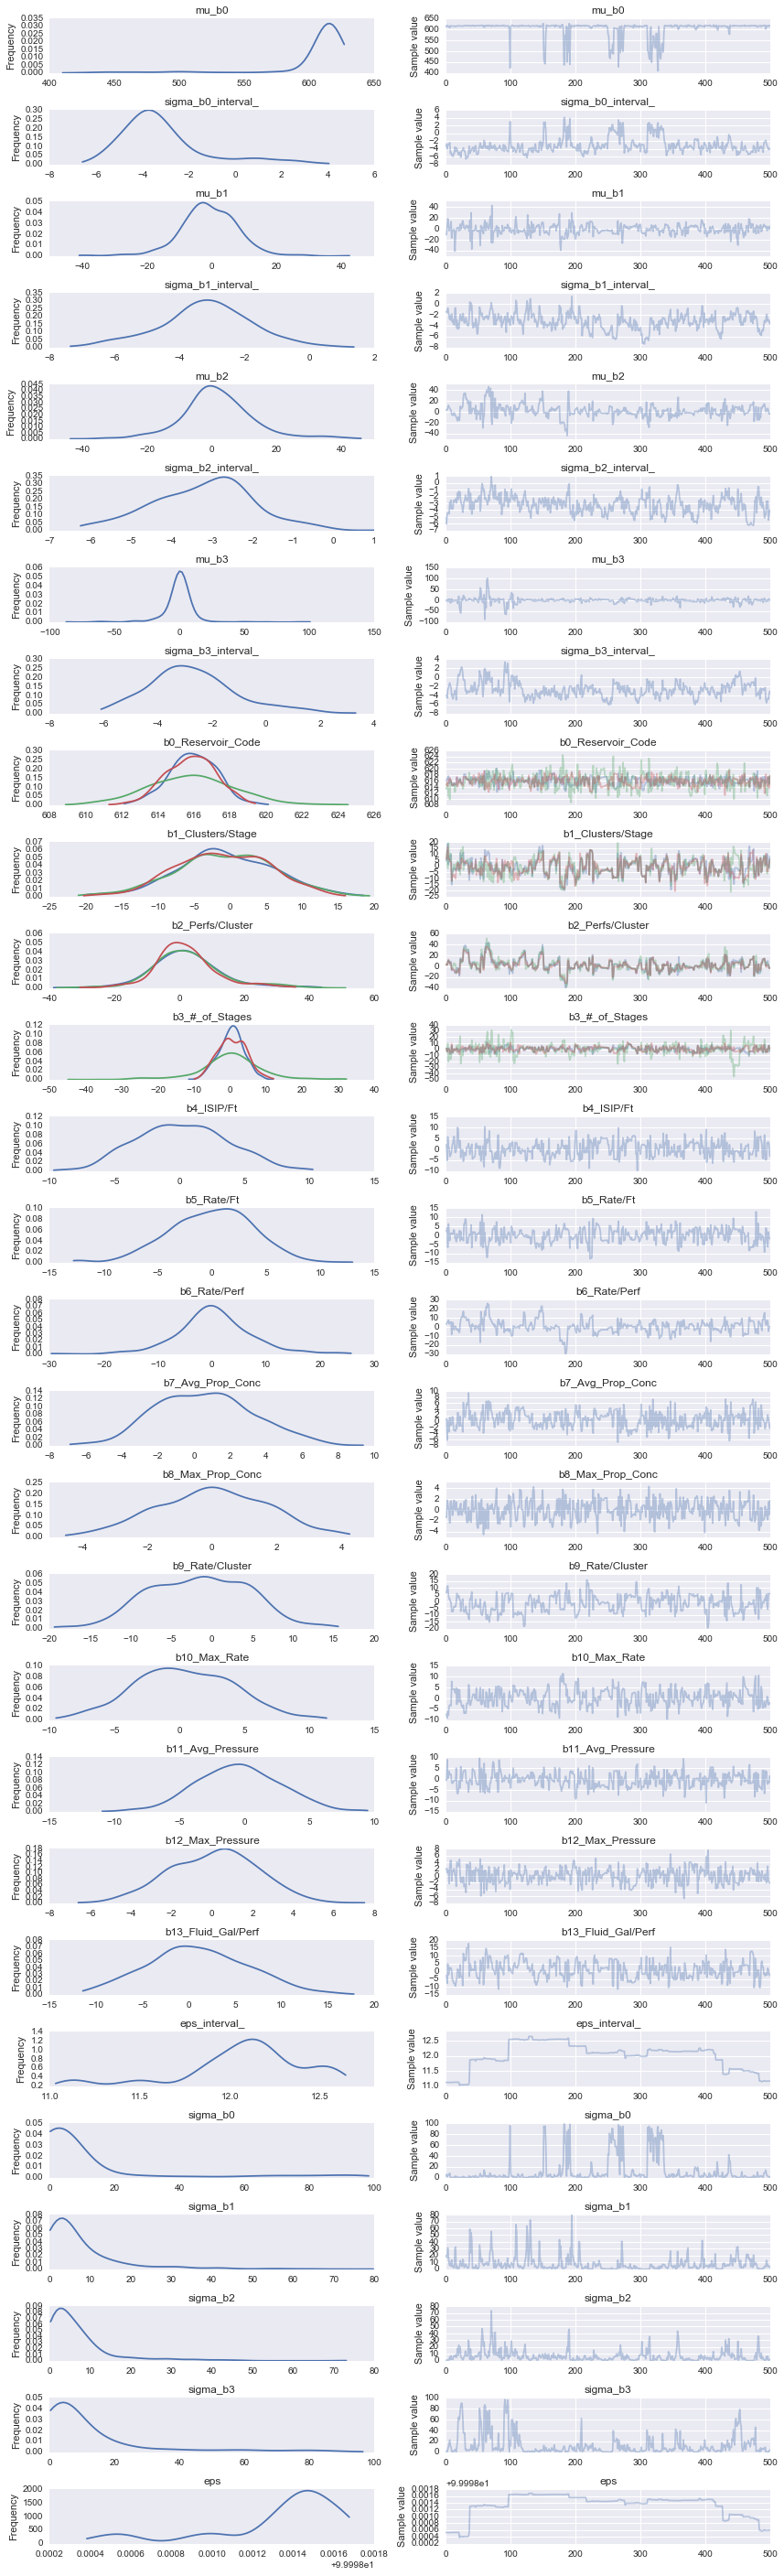

In [67]:
rvs_reservoir = [rv.name for rv in mdl_reservoir.unobserved_RVs]
ax = pm.traceplot(trc_reservoir[-500:], varnames=rvs_reservoir, figsize=(12,len(rvs_reservoir)*1.4), combined=False)


In [68]:
pm.df_summary(trc_reservoir[-500:])


,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_b0,603.517668,37.101770,2.886714,496.257017,620.521782
mu_b1,-0.964355,9.192852,0.519648,-19.156134,15.333207
mu_b2,1.843069,11.595277,0.865706,-23.193870,27.005038
mu_b3,-0.371100,13.505736,0.738484,-25.876952,19.782620
b0_Reservoir_Code__0,615.947113,1.327096,0.072949,613.431273,618.531045
b0_Reservoir_Code__1,615.873165,2.461630,0.146916,610.950191,620.420913
b0_Reservoir_Code__2,615.821610,1.390986,0.085972,613.250217,618.455314
b1_Clusters/Stage__0,-0.563264,6.789025,0.493674,-11.937152,14.771245
b1_Clusters/Stage__1,-0.645716,6.931965,0.489905,-12.927327,13.458891
b1_Clusters/Stage__2,-1.007238,6.405428,0.477798,-12.481543,11.232114


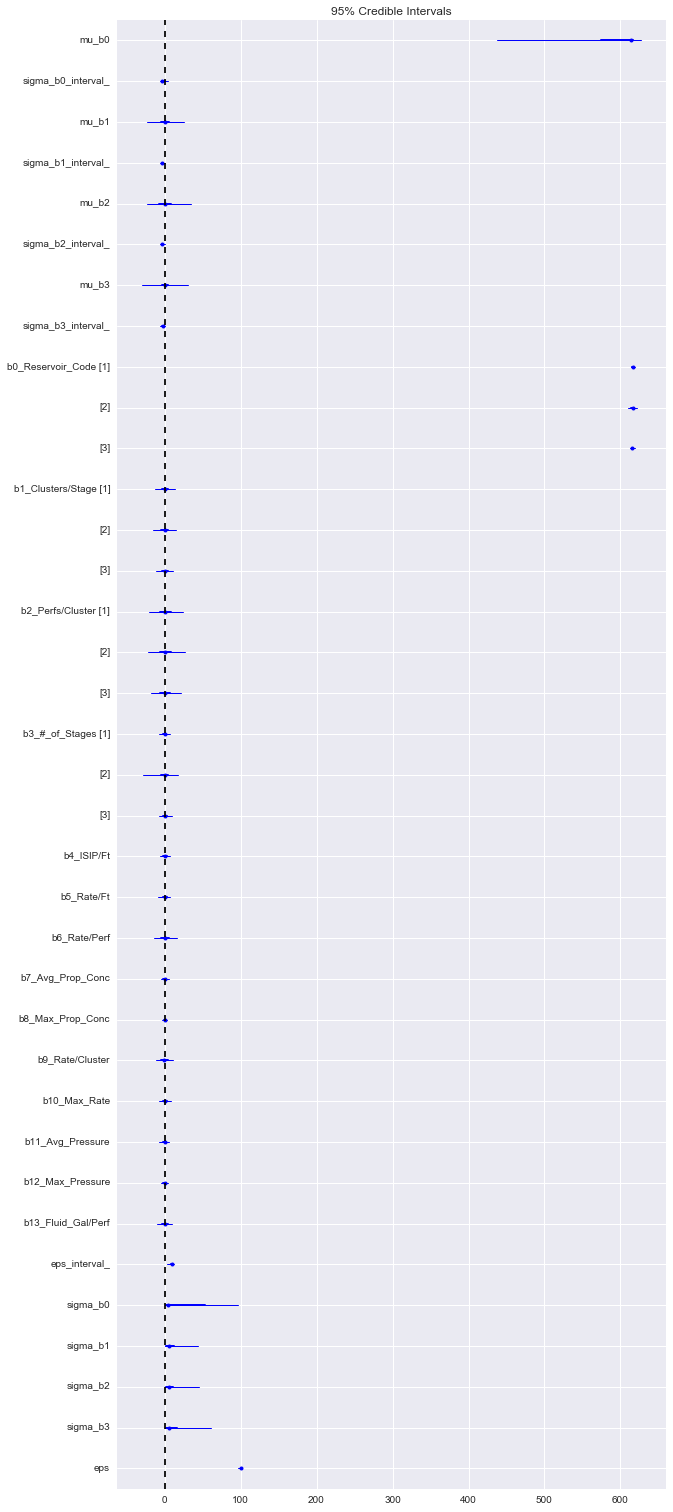

In [69]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_reservoir)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


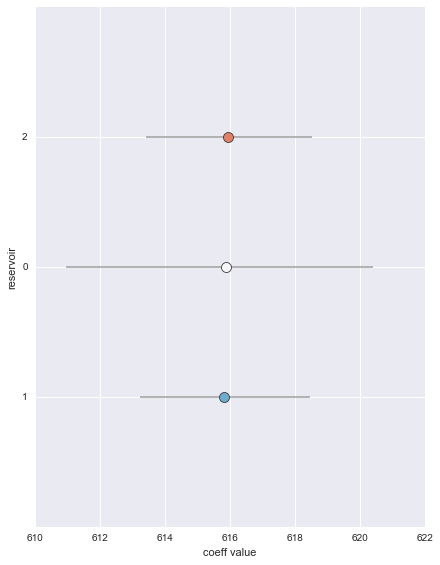

In [70]:
dfsm_reservoir_field = create_smry(trc_reservoir[-500:], X_train, 'Reservoir_Code')
custom_forestplot(dfsm_reservoir_field)


In [37]:
X_train.groupby(['Reservoir_Code'])['Reservoir_Code'].count()


Reservoir_Code
0    69
1     9
2    55
Name: Reservoir_Code, dtype: int64

In [71]:
ppc_reservoir = pm.sample_ppc(trc_reservoir[-500:], samples=500, model=mdl_reservoir, size=50)
y_pred_reservoir = ppc_reservoir['likelihood'].mean(axis=1).mean(axis=0)


In [72]:
y_pred_reservoir

array([ 614.81754538,  615.02789703,  616.22003694,  615.93281461,
        615.7501337 ,  617.24932636,  615.77938749,  614.56932028,
        616.16662811,  616.19672508,  615.92788264,  615.99762877,
        614.56429497,  615.38084991,  615.82083315,  613.82053518,
        615.97441283,  616.65331167,  616.64711645,  615.34576971,
        616.16129008,  614.39498488,  615.2690793 ,  616.59366062,
        615.12930628,  615.93276803,  614.60590241,  616.30163074,
        615.54823559,  616.21130581,  616.44672269,  616.43935115,
        615.3256826 ,  615.32274631,  615.84452557,  616.01529372,
        615.82047446,  614.60261743,  614.80876469,  615.64542251,
        614.83129626,  614.90766693,  616.88448357,  616.5982692 ,
        614.98387266,  616.16473894,  615.3486945 ,  615.52265975,
        615.8288235 ,  614.3436474 ,  617.17530056,  615.80038196,
        616.38500094,  615.95439699,  615.36629578,  615.45557587,
        616.00060847,  615.19798933,  617.19964364,  615.80839